In [ ]:
# start with https://www.pyimagesearch.com/2018/05/07/multi-label-classification-with-keras/

In [ ]:
# import tensorflow as tf
# from keras.backend.tensorflow_backend import set_session
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.5
# set_session(tf.Session(config=config))

# from keras import backend as K
# K.tensorflow_backend._get_available_gpus()

In [ ]:
# from keras import backend as K
# import tensorflow as tf
# with K.tf.device("/device:GPU:0"):
#     config = tf.ConfigProto(intra_op_parallelism_threads=4,\
#            inter_op_parallelism_threads=4, allow_soft_placement=True,\
#            device_count = {'CPU' : 1, 'GPU' : 1})
#     session = tf.Session(config=config)
#     K.set_session(session)

In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

/home/lovely/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1410372447093695272, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1401421824
 locality {
   bus_id: 1
 }
 incarnation: 16398755870384322347
 physical_device_desc: "device: 0, name: GeForce 940MX, pci bus id: 0000:01:00.0, compute capability: 5.0"]

In [60]:
import os
import librosa
import numpy as np
import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import backend as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from python_speech_features import base as b
%matplotlib inline

In [3]:
# multiclass classification task

In [4]:
# helpers
def compute_mfcc():
    pass

winlen = 0.025 # the length of the analysis window in seconds (25 milliseconds)
winstep = 0.01    # the step between successive windows in seconds (10 milliseconds)
preemph = 0.97   # coefficient

nfilt = 40 # ?? the number of filters in the filterbank, default 26.
nfft = 512 * 3 # ?? the FFT size. Default is 512.

numcep = 13 # ?? num of cepstral coefs
ceplifter = 0 # apply a lifter to final cepstral coefficients. 0 is no lifter 22

winfunc = np.kaiser # lambda x: np.ones((x,)) # window function

In [5]:
classes = np.array(['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised'])

In [6]:
# at first we need to generate mfcc coeffs for all audios

all_mel_cepstral_coefficients = []
all_class_labels = []

path = 'RAVDESS/renamed_sources/'

min_signal_length = 147347

for file in os.listdir(path):

    signal, samplerate = librosa.core.load(path+file, sr=48000)
    
    class_label = file.split('-')[0]
    class_label = np.where(classes == class_label)[0][0]

    mfccs = b.mfcc(\
                signal[:min_signal_length], \
                nfft=nfft,\
                appendEnergy=True,\
                samplerate=samplerate,\
                numcep=numcep,
                nfilt=nfilt
              )
    
    all_mel_cepstral_coefficients.append(mfccs)
    all_class_labels.append(class_label)

/home/lovely/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)


In [7]:
all_mel_cepstral_coefficients = np.array(all_mel_cepstral_coefficients)
print(all_mel_cepstral_coefficients.shape)

all_class_labels = np.array(all_class_labels)
print(all_class_labels.shape)

(360, 306, 13)
(360,)


In [8]:
num_of_classes = len(set(all_class_labels))# 8
all_class_labels[:5]

array([3, 2, 1, 4, 5])

In [34]:
min_ = np.amax(all_mel_cepstral_coefficients)
max_ = np.amin(all_mel_cepstral_coefficients)

In [36]:
rescaled = (all_mel_cepstral_coefficients - min_) / (max_ - min_)

In [37]:
X = rescaled.reshape(rescaled.shape[0], rescaled.shape[1],13,1)
Y = keras.utils.to_categorical(all_class_labels, num_of_classes)

In [38]:
X.shape, Y.shape

((360, 306, 13, 1), (360, 8))

In [25]:
# X no any normalization - ploho

# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler(feature_range=(0, 1))
# rescaledX_train = scaler.fit_transform(X_train)

In [29]:
# scaler = MinMaxScaler()

In [30]:
# scaler.fit_transform(all_mel_cepstral_coefficients)

In [40]:
np.random.seed(7)

In [85]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

In [86]:
model = models.Sequential()
model.add(layers.Conv2D(20, kernel_size=5,padding='same', input_shape=X.shape[1:]))
model.add(layers.Activation('relu'))
model.add(layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(num_of_classes))
model.add(layers.Lambda(lambda x: K.tf.nn.softmax(x)))
# model.add(layers.Activation('softmax'))
# model.summary()

In [87]:
# https://www.kaggle.com/olgabelitskaya/multi-label-classification-models
# model.compile(loss='binary_crossentropy', optimizer='sgd',metrics=['accuracy'])
# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy',])
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [88]:
history = model.fit(X_train, Y_train, validation_split=0.2, batch_size=10, epochs=15, verbose=True)

Train on 216 samples, validate on 54 samples
Epoch 1/15
216/216 [==============================] - 1s 4ms/step - loss: 2.1585 - acc: 0.0833 - val_loss: 2.0603 - val_acc: 0.1296
Epoch 2/15
216/216 [==============================] - 0s 1ms/step - loss: 2.0558 - acc: 0.1806 - val_loss: 2.0467 - val_acc: 0.1667
Epoch 3/15
216/216 [==============================] - 0s 1ms/step - loss: 1.9985 - acc: 0.2454 - val_loss: 2.2373 - val_acc: 0.0741
Epoch 4/15
216/216 [==============================] - 0s 1ms/step - loss: 1.9121 - acc: 0.2917 - val_loss: 2.0183 - val_acc: 0.2037
Epoch 5/15
216/216 [==============================] - 0s 1ms/step - loss: 1.8599 - acc: 0.3009 - val_loss: 2.1768 - val_acc: 0.1852
Epoch 6/15
216/216 [==============================] - 0s 1ms/step - loss: 1.7246 - acc: 0.4259 - val_loss: 2.0856 - val_acc: 0.1481
Epoch 7/15
216/216 [==============================] - 0s 1ms/step - loss: 1.5625 - acc: 0.4861 - val_loss: 2.1009 - val_acc: 0.0556
Epoch 8/15
216/216 [===========

In [89]:
model.evaluate(X_test, Y_test)

90/90 [==============================] - 0s 225us/step


[2.123725700378418, 0.2888888892200258]

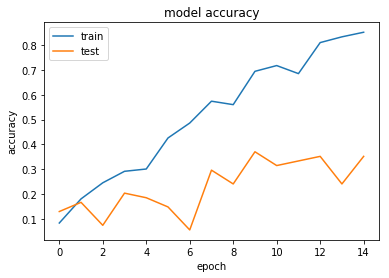

In [90]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.plot(history.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

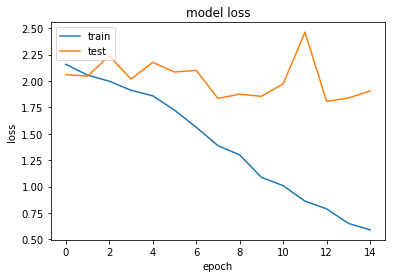

In [91]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
model.evaluate??

In [20]:
model.metrics_names

['loss', 'acc']

In [ ]:
# pip3 install --upgrade keras==2.1.3